In [1]:
from google.colab import files
uploaded = files.upload()

Saving cleaned_loan_approval_dataset.csv to cleaned_loan_approval_dataset.csv


<ipython-input-2-f94a5c5a72d3>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['loan_status'] = df['loan_status'].str.strip().replace({'Approved': 1, 'Rejected': 0})


Accuracy: 0.9964871194379391
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       318
           1       1.00      1.00      1.00       536

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



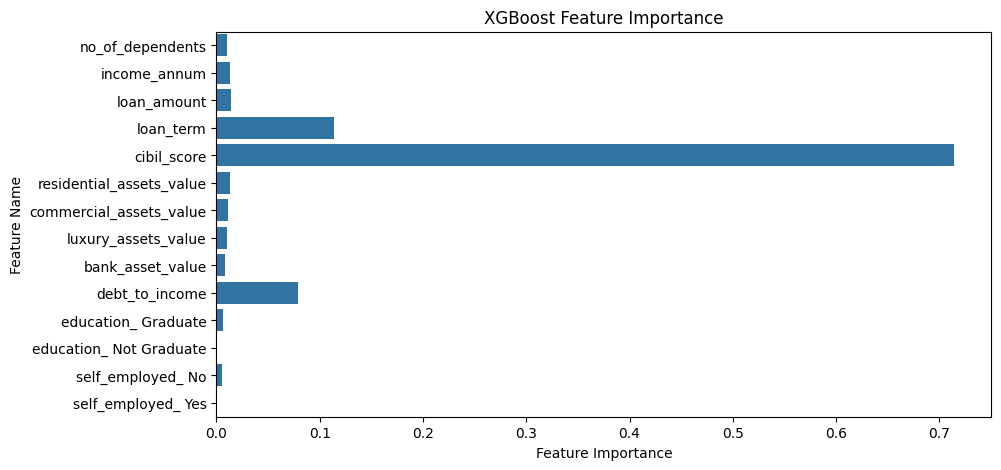

Loan Status: Approved
Approval Probability: 0.89


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv('cleaned_loan_approval_dataset.csv')

# Fix loan_status encoding (ensure Approved=1, Rejected=0)
df['loan_status'] = df['loan_status'].str.strip().replace({'Approved': 1, 'Rejected': 0})

# Feature Engineering: Create Debt-to-Income Ratio
df['debt_to_income'] = df['loan_amount'] / df['income_annum']

# Handle missing values (fill with median for numerical, mode for categorical)
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['education', 'self_employed'])

# Define features and target
X = df.drop(columns=['loan_status', 'loan_id'])  # Removing loan_id as it has no predictive power
y = df['loan_status']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train optimized XGBoost model with adjusted parameters
model_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,  # Reduced depth to avoid overfitting
    learning_rate=0.05,
    colsample_bytree=0.9,  # Use more features per tree
    subsample=0.9,  # Use more samples per tree
    gamma=1,  # Add regularization to reduce dominance of any single feature
    random_state=42
)
model_xgb.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = model_xgb.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x=model_xgb.feature_importances_, y=X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importance")
plt.show()

# Function to test new loan applications
def predict_loan_approval(new_application):
    """Predict loan approval for a new application."""
    new_application = pd.DataFrame([new_application])

    # Compute Debt-to-Income Ratio
    if 'income_annum' in new_application.columns and 'loan_amount' in new_application.columns:
        new_application['debt_to_income'] = new_application['loan_amount'] / new_application['income_annum']

    # Check if categorical columns exist before encoding
    for col in ['education', 'self_employed']:
        if col in new_application.columns:
            new_application = pd.get_dummies(new_application, columns=[col])

    # Ensure feature order matches training data
    new_application = new_application.reindex(columns=X.columns, fill_value=0)
    new_application_scaled = scaler.transform(new_application)
    prediction = model_xgb.predict(new_application_scaled)[0]
    probability = model_xgb.predict_proba(new_application_scaled)[:, 1][0]
    status = "Approved" if prediction == 1 else "Rejected"
    print(f"Loan Status: {status}\nApproval Probability: {probability:.2f}")

# Example Test Case (High CIBIL Score, Low Loan Amount)
test_case = {
    "income_annum": 80000,
    "loan_amount": 5000,
    "cibil_score": 800,
    "loan_term_years": 3,
    "no_of_dependents": 1,
    "education_Graduate": 1,
    "self_employed_Yes": 0
}
predict_loan_approval(test_case)
